In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom, binary_fill_holes
import nibabel as nib
path = r"D:\nsclc\data\nnUNet_raw\Dataset001_Apm\imagesTr\Lung1-123_0000.nii.gz"

In [2]:
ct = nib.load(path)
img = ct.get_fdata()
print(f"shape: {img.shape}")
print(f"min: {img.min()}")
print(f"max: {img.max()}")

shape: (512, 512, 114)
min: -1024.0
max: 3071.0


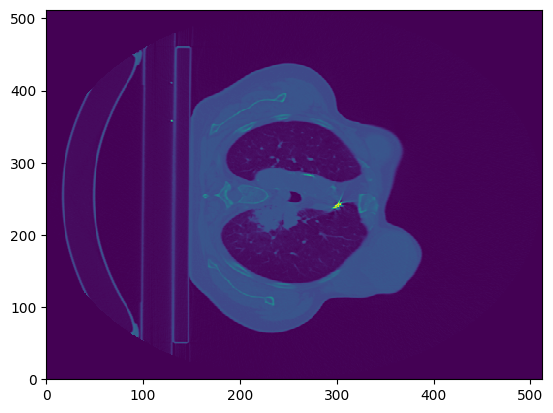

In [3]:
plt.pcolormesh(img[:, :, 70])

In [4]:
# put smallest dimension in axis 0
def get_axes_maps(tensor):
    """
    This function takes a tensor and returns a mapping of axes and the reverse mapping.
    """
    # Create a mapping of axes
    axes_map = {i: (len(tensor.shape) - 1 - i) for i in range(len(tensor.shape))}
    # Create the reverse mapping
    reverse_map = {v: k for k, v in axes_map.items()}
    return axes_map, reverse_map

def transpose_tensor(tensor, axes_map):
    """
    This function takes a tensor and an axes map, and returns the transposed tensor.
    """
    # Get the list of axes for transposition
    axes = [axes_map[i] for i in range(len(tensor.shape))]
    # Perform the transposition
    return np.transpose(tensor, axes=axes)

axes_map, reverse_map = get_axes_maps(img)
print(axes_map, reverse_map)
img = transpose_tensor(img, axes_map)

{0: 2, 1: 1, 2: 0} {2: 0, 1: 1, 0: 2}


Hounsfiled Units
$$ HU =  10^{3} * \frac{a_{pixel} - a_{water}}{a_{water} - a_{air}}$$
$ a $ stands for attenuation, the higher the value in a region, the higher the probability x-rays are absorbed in said region

reference values

air = -1000, duh

water = 0, duh

soft tissue on contrast = 100 to 300

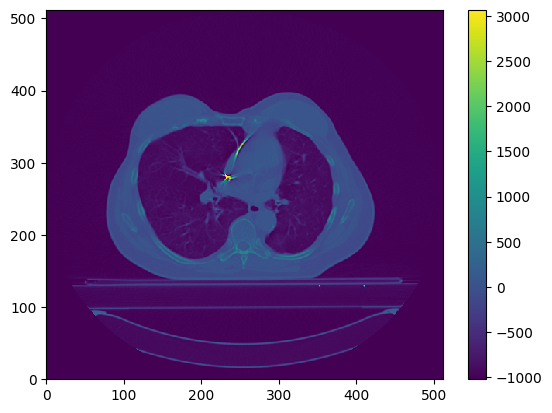

In [5]:
default_slice = 50
def plot_slice(img, slice_num_1 =  default_slice):
    #pcolormesh and colorbar, slice on axis 0, in colorbar, denot it is HU (Hounsfield Unit)
    plt.pcolormesh(img[slice_num_1,:,:])
    plt.colorbar()
    plt.show()
def comparison_plot(img1, img2, slice_num_1 = default_slice):
    fig, ax = plt.subplots(1, 2)
    #for first use colormesh
    ax[0].imshow(img1[slice_num_1,:,:])
    #for second use imshow
    ax[1].imshow(img2[slice_num_1,:,:])
    plt.show()
def thorough_plot(img1, img2, num_slices=10, start=default_slice - 5, spacing=0.02):
    # num_slices rows and 2 columns, dense plot
    fig, ax = plt.subplots(num_slices, 2, figsize=(8, num_slices * 4))
    
    # Adjust horizontal spacing
    fig.subplots_adjust(wspace=spacing)
    
    for i in range(num_slices):
        ax[i, 0].imshow(img1[start + i, :, :])
        ax[i, 1].imshow(img2[start + i, :, :])
        # no coordinates for x and y
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
    
    plt.show()

    

plot_slice(img)

Number of labels: 41


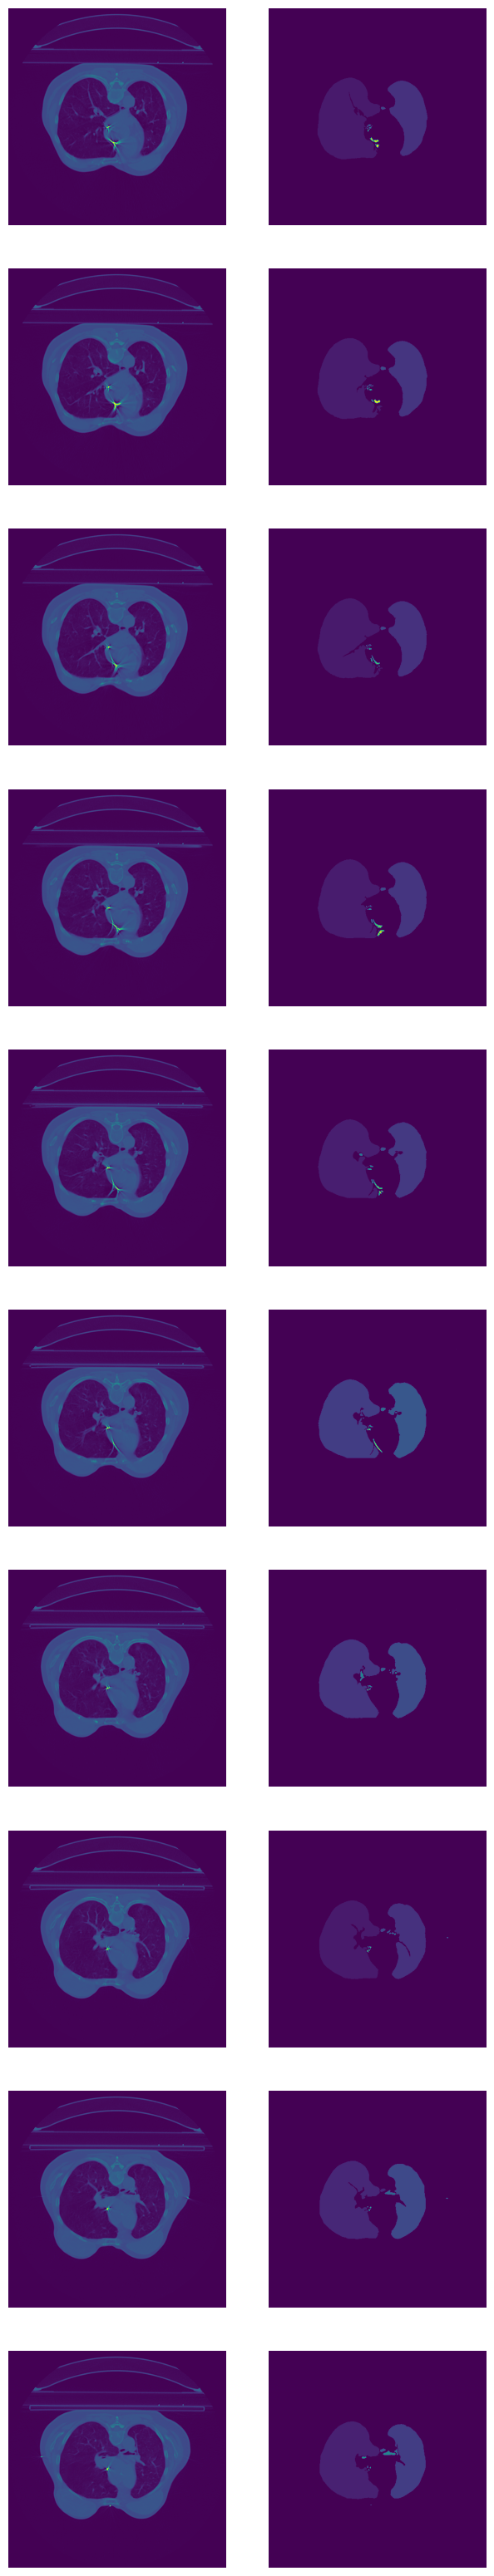

In [6]:
mask = img < -400

mask = np.vectorize(clear_border, signature='(m,n)->(m,n)')(mask)
mask = np.vectorize(binary_fill_holes, signature='(m,n)->(m,n)')(mask)

mask_label = np.vectorize(label, signature='(m,n)->(m,n)')(mask)
#count the number of labels
num_labels = np.max(mask_label)
print(f"Number of labels: {num_labels}")
#set number of labels to keep to either 5 or sqrt of number of labels, whichever is smaller
num_labels_to_keep = min(5, int(np.sqrt(num_labels)))





thorough_plot(img, mask_label)

In [7]:
#return back to original orientation
img = transpose_tensor(img, reverse_map)
mask = transpose_tensor(mask, reverse_map)
mask.shape

(512, 512, 114)

In [8]:
#niband save to nii.gz the mask, use the original ct as a template
mask_nii = nib.Nifti1Image(mask, ct.affine, ct.header)
#nib.save(mask_nii, r"D:\nsclc\data\nnUNet_raw\Dataset001_Apm\imagesTr\Lung1-015_0000_mask.nii.gz")

In [9]:
path = r"D:\nsclc\data\nnUNet_preprocessed\Dataset002_Apmcopy\nnUNetPlans_2d"

l1_npz = np.load(path + r"\LUNG1-001.npz")

print(l1_npz.files)

data, seg = l1_npz['data'], l1_npz['seg']
print(f"Data shape: {data.shape}")
print(f"Seg shape: {seg.shape}") 
# it has only one element, get the first one
data, seg = data[0], seg[0]
print(f"Data shape: {data.shape}")
print(f"Seg shape: {seg.shape}")

['data', 'seg']
Data shape: (1, 134, 512, 512)
Seg shape: (1, 134, 512, 512)
Data shape: (134, 512, 512)
Seg shape: (134, 512, 512)


In [10]:
#get values distribution of data
print(f"Min: {data.min()}")
print(f"Max: {data.max()}")
print(f"Mean: {data.mean()}")
print(f"Std: {data.std()}")
#plot the slice

Min: -0.9575223922729492
Max: 1.3956927061080933
Mean: -0.5364107489585876
Std: 0.6574038863182068


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom, binary_fill_holes, gaussian_filter1d
import nibabel as nib
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import os
import numpy as np
import pickle
import pickle


# put smallest dimension in axis 0
def get_axes_maps(tensor):
    """
    This function takes a tensor and returns a mapping of axes and the reverse mapping.
    """
    # Create a mapping of axes
    axes_map = {i: (len(tensor.shape) - 1 - i) for i in range(len(tensor.shape))}
    # Create the reverse mapping
    reverse_map = {v: k for k, v in axes_map.items()}
    return axes_map, reverse_map

def transpose_tensor(tensor, axes_map):
    """
    This function takes a tensor and an axes map, and returns the transposed tensor.
    """
    # Get the list of axes for transposition
    axes = [axes_map[i] for i in range(len(tensor.shape))]
    # Perform the transposition
    return np.transpose(tensor, axes=axes)


def calculate_percentage_inside(mask_lung, mask_seg):
    intersection = np.logical_and(mask_lung, mask_seg).sum()
    seg_size = mask_seg.sum()
    if seg_size == 0:
        return 0
    else:
        return (intersection / seg_size)

path = r"D:\nsclc\data\nnUNet_raw\Dataset002_Thesis\imagesTr"
output_path = r"D:\nsclc\data\nnUNet_raw\Dataset002_Thesis\lung_extraction"
seg_path = r"D:\nsclc\data\nnUNet_raw\Dataset002_Thesis\labelsTr"

#if dir does not exist, create it
if not os.path.exists(output_path):
    print("sarai fesso, oh...")
    os.makedirs(output_path)


experimental = False
shqiperia = True
check_mask = True

up_adjust = 0.05

left_adjust = 5
right_adjust = 5
percentages = []
files = sorted(os.listdir(path))
for i in tqdm(range(len(files)), colour='red', desc='segmenting for you baby ;)'):
    file = files[i]


    
    file_path = os.path.join(path, file)
    # if it already exists, skip
    if shqiperia is True and os.path.exists(os.path.join(output_path, file)): 
        #print(f"Skipping {file}")
        continue
    print(f"file is {file}")

    case = nib.load(file_path)
    img = case.get_fdata()

    axes_map, reverse_map = get_axes_maps(img)
    img = transpose_tensor(img, axes_map)

    
    min_val = np.min(img)
    # Pad tensor over axis 1 and 2 with min_val
    padded_tensor = np.pad(img, ((0,0), (10,10), (10,10)), 'constant', constant_values=min_val)

    img = padded_tensor
    body_seg = np.logical_and(img >= -500, img <= 2000).astype(int)


    # Find the air segmentation by inverting the body segmentation
    air_seg = 1 - body_seg
    
    air_percentages = np.sum(air_seg, axis=(1, 2)) / (air_seg.shape[1] * air_seg.shape[2])
    # we find and remove the slices that are mostly air above the torso and shoulders, these we can easily say are above the lungs and the trachea
    all_air_from_here = np.argwhere(air_percentages[::-1] < 0.9)[0][0]
    all_air_from_here = len(air_percentages) - 1 - all_air_from_here
    # sometimes though the air part is spotted in this method below the lungs, this can happen in a very tight ct and thus the first part could be below the hips
    # if this is indeed the case, we just do nothing
    if all_air_from_here >= 0.9 * len(air_percentages):
        air_percentages = air_percentages[:all_air_from_here]

    # this part is though out to avoid directly connecting the outside air to the lungs#
    # it finds the last sudden decrease in axial air percentage, there can be many points where the air percentage decreases, but we are interested in the last one as this should indicate the lungs ending
    # we have already removed mostly air slices above the torso and shoulders, so we can be sure that the last sudden decrease is the lungs ending
        
    #the derivative is smoothed with a gaussian filter
    air_percentages_derivative = gaussian_filter1d(np.gradient(air_percentages), sigma = 3)
    #set distance as 1/5 th of the length of the air_percentages_derivative, this avoid taking an irrelevant peak
    peaks, _ = find_peaks(-air_percentages_derivative, distance = len(air_percentages_derivative) // 5)
    
    # this should never happen, but just in case
    if len(peaks) < 1:
        raise Exception("couldn't find any peaks boss :/")

    index = peaks[-1]
    # increase index by up_adjust percent of length, this is to avoid cutting the lungs early
    index = int(index + up_adjust * len(air_percentages))
    #plt.plot(air_percentages_derivative)
    #plot peaks as vertical lines
    #plt.vlines(peaks, ymin = air_percentages_derivative.min(), ymax = air_percentages_derivative.max(), color = 'r')
    #remove all slice after index from air_seg

    #remove all slices after index
    air_seg[index:, :, :] = 0

        
    # also remove everything with axis2 < 100, this removes the bed
    air_seg[:, :100, :] = 0


    # Label different components in the air segmentation
    air_seg_labeled = label(air_seg, background=0)
 
    # Find the largest connected component in the air segmentation (this should be the outside air)
    # and remove it from the segmentation
    largest_air_component = air_seg_labeled == np.argmax(np.bincount(air_seg_labeled.flat)[1:]) + 1
    air_seg_cleaned = air_seg - largest_air_component
    
    

    

    # Repeat the process to segment the lungs (which are now the largest air-filled areas in the image)
    lung_seg_labeled = label(air_seg_cleaned, background=0)
    

    largest_lung_component = lung_seg_labeled == np.argmax(np.bincount(lung_seg_labeled.flat)[1:]) + 1

    # dilate the lung segmentation
    largest_lung_component = binary_dilation(largest_lung_component, iterations=10)
    # fill holes in the lung segmentation
    largest_lung_component = binary_fill_holes(largest_lung_component)

    
    

    # Assuming the shape of largest_lung_component is (z, x, y)
    # And the padding was ((0,0), (10,10), (10,10))
    # We can remove the padding by slicing the array from 10 to -10 on the second and third dimensions

    largest_lung_component = largest_lung_component[:, 10:-10, 10:-10]
    
        

    # give the mask the same orientation as the original image
    largest_lung_component = transpose_tensor(largest_lung_component, reverse_map)

    if check_mask is True:
        seg_file = os.path.join(seg_path, file.replace("_0000.nii.gz", ".nii.gz"))
        seg = nib.load(seg_file).get_fdata()

        # get the percentage of the segmentation inside the lung mask
        percentage = calculate_percentage_inside(largest_lung_component, seg)
        percentages.append((file, percentage))
        print(f"Percentage of segmentation inside the lung mask: {percentage * 100:.2f}%")
    # save the mask
    mask_nii = nib.Nifti1Image(largest_lung_component, case.affine, case.header)
    # save the mask with the same name as the original image
    nib.save(mask_nii, os.path.join(output_path, file))

# save the percentages
if check_mask is True:
    with open(os.path.join(output_path, "percentages.pkl"), "wb") as f:
        pickle.dump(percentages, f)
    



#
print("done")

segmenting for you baby ;):   0%|          | 0/294 [00:00<?, ?it/s]

done


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom, binary_fill_holes
import nibabel as nib
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import os
import numpy as np


seg_path = r"D:\nsclc\data\nnUNet_raw\Dataset002_Thesis\labelsTr"

segs = sorted(os.listdir(seg_path))
for i in tqdm(range(len(segs)), desc='dealing with BULLSHIT'):
    seg = segs[i]
    seg_file = os.path.join(seg_path, seg)
    img = nib.load(seg_file).get_fdata()
    # get percentage of pixels != 0
    
    percentage = np.count_nonzero(img) / img.size
    if percentage > 0.33:
        print(f"SUS: {seg} has a percentage of {percentage * 100:.2f}%")





dealing with BULLSHIT:   0%|          | 0/294 [00:00<?, ?it/s]

SUS: INT1010431.nii.gz has a percentage of 97.39%
SUS: INT1010593.nii.gz has a percentage of 97.37%


<AxesSubplot:ylabel='Count'>

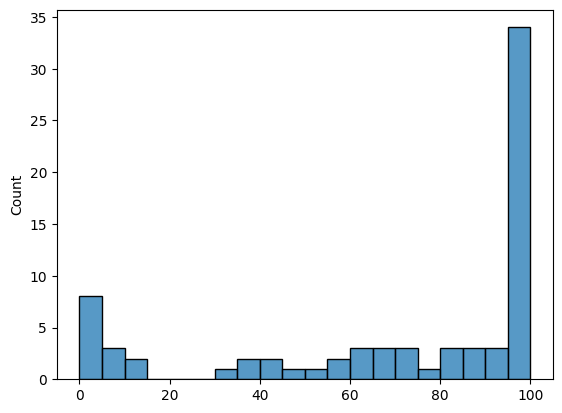

In [12]:
vals = [y for x,y in percentage_list]
import seaborn as sns
sns.histplot(vals, bins = 20)
